In [1]:
from pyspark.sql import SparkSession
import pickle

# 初始化 SparkSession
spark = SparkSession.builder.appName("TowTowerModel").config(
    "spark.driver.memory", "8g").getOrCreate()

# 加载数据集
train_df = spark.read.parquet("./data/two_tower_data/train_df.parquet")
val_df = spark.read.parquet("./data/dcn_data/val_df.parquet")
user_df = spark.read.parquet("./data/user_df.parquet")
movie_df = spark.read.parquet("./data/movie_df.parquet")

with open('./data/user_FeatureVector_dict.pickle', 'rb') as f1:
    user_FeatureVector_dict = pickle.load(f1)

with open('./data/movie_FeatureVector_dict.pickle', 'rb') as f2:
    movie_FeatureVector_dict = pickle.load(f2)


24/08/31 16:56:03 WARN Utils: Your hostname, yvjie-Lenovo-Legion-Y7000-2019-1050 resolves to a loopback address: 127.0.1.1; using 172.24.70.50 instead (on interface wlp0s20f3)
24/08/31 16:56:03 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


24/08/31 16:56:04 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/08/31 16:56:05 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [2]:
all_movie_set = set(movie_FeatureVector_dict.keys())
all_user_set = set(user_FeatureVector_dict.keys())

import random

train_list = train_df.rdd.map(lambda row: [row['user_id'], row['movie_id'], row['label']]).collect()
val_list = val_df.rdd.map(lambda row: [row['user_id'], row['movie_id'], row['label']]).collect()
random.shuffle(train_list)
random.shuffle(val_list)

In [3]:
test_df = spark.read.parquet("./data/test_df.parquet")
test_list = test_df.rdd.map(lambda row: [row['user_id'], row['movie_id'], row['label']]).collect()
random.shuffle(test_list)

In [3]:
import torch
from torch.utils.data import DataLoader, TensorDataset

def create_dataloader(dataset_list, user_FeatureVector_dict, movie_FeatureVector_dict):
    users_feature = []
    movies_feature = []
    labels = []

    for sample in dataset_list:
        user_feature = user_FeatureVector_dict[sample[0]]
        movie_feature = movie_FeatureVector_dict[sample[1]]
        label = sample[2]
        users_feature.append(user_feature)
        movies_feature.append(movie_feature)
        labels.append(label)
    # 转换为Tensor
    user_features_tensor = torch.tensor(users_feature).to(dtype=torch.float32)
    movie_features_tensor = torch.tensor(movies_feature).to(dtype=torch.float32)
    targets_tensor = torch.tensor(labels).to(dtype=torch.float32)
    # 创建TensorDataset
    dataset = TensorDataset(user_features_tensor, movie_features_tensor, targets_tensor)
    data_loader = DataLoader(dataset, batch_size=64, shuffle=True)
    return data_loader

train_loader = create_dataloader(train_list, user_FeatureVector_dict, movie_FeatureVector_dict)
val_loader = create_dataloader(val_list, user_FeatureVector_dict, movie_FeatureVector_dict)


双塔模型

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init


class FeatureEmbedder(nn.Module):
    def __init__(self, num_embeddings, embedding_dim):
        super(FeatureEmbedder, self).__init__()
        self.embedding = nn.Embedding(num_embeddings, embedding_dim)
        init.normal_(self.embedding.weight, mean=0.0, std=0.01)  # 正态分布初始化

    def forward(self, x):
        return self.embedding(x)


class TwoTowerModel(nn.Module):
    def __init__(self, user_num, movie_num, user_feature_dim, movie_feature_dim, embedding_dim, embed_dim):
        super(TwoTowerModel, self).__init__()
        # self.l2_reg = l2_reg  # L2正则化系数

        # 用户塔
        self.user_embed = FeatureEmbedder(user_num, embedding_dim)
        self.user_fc = nn.Sequential(
            nn.Linear(embedding_dim + user_feature_dim, embed_dim),
            nn.BatchNorm1d(embed_dim),
            nn.ReLU(),
        )

        # 物品塔
        self.movie_embed = FeatureEmbedder(movie_num, embedding_dim)
        self.movie_fc = nn.Sequential(
            nn.Linear(embedding_dim + movie_feature_dim, embed_dim),
            nn.BatchNorm1d(embed_dim),
            nn.ReLU(),
        )

    def forward(self, user_features, movie_features):
        user_embedded = self.get_user_embedding(user_features)
        movie_embedded = self.get_movie_embedding(movie_features)
        # 计算余弦相似度 dim默认为1
        cosine_similarity = torch.sum(user_embedded * movie_embedded, dim=1)
        return cosine_similarity
    
    
    def get_user_embedding(self, user_features):
        # 用户塔的嵌入
        user_embedded = torch.cat([
            self.user_embed(user_features[:, 0].int()),
            user_features[:, 1:]
        ], dim=1).to(dtype=torch.float32)
        # 用户塔的全连接层
        user_output = self.user_fc(user_embedded)
        # 对输出向量进行 L2 归一化
        user_output_normalized = F.normalize(user_output, p=2, dim=1)
        return user_output_normalized

    def get_movie_embedding(self, movie_features):
        # 物品塔的嵌入
        movie_embedded = torch.cat([
            self.movie_embed(movie_features[:, 0].int()),
            movie_features[:, 1:]
        ], dim=1).to(dtype=torch.float32)
        # 物品塔的全连接层
        movie_output = self.movie_fc(movie_embedded)
        movie_output_normalized = F.normalize(movie_output, p=2, dim=1)
        return movie_output_normalized


# 余弦损失函数
def binary_cross_entropy_loss(cos_sim, labels):
    # 计算二元交叉熵损失
    loss = F.binary_cross_entropy_with_logits(cos_sim, labels.float(), reduction='mean')
    return loss

def cosine_loss(cos_sim, labels):
    loss = torch.where(labels == 1, 1 - cos_sim, torch.clamp(cos_sim, min=0))
    return loss.mean()


# 假设age_categories是年龄独热编码的类别数
user_num = 6041
movie_num = 3707
age_categories = 7
occupation_categories = 21
user_rating_categories = 8
genres_categories = 18
movie_rating_categories = 8
user_feature_dim = age_categories + occupation_categories + user_rating_categories + 1
movie_feature_dim = genres_categories + movie_rating_categories
embedding_dim = 128
embed_dim = 64
dropout = 0.2


# 初始化双塔模型
recall_model = TwoTowerModel(\
    user_num, movie_num, user_feature_dim, movie_feature_dim, embedding_dim, embed_dim)


训练模型

Epoch 1/5


Evaluation Progress: 100%|██████████| 36807/36807 [00:58<00:00, 627.12it/s]


Best F1 score: 0.6781
Best threshold: 0.5015


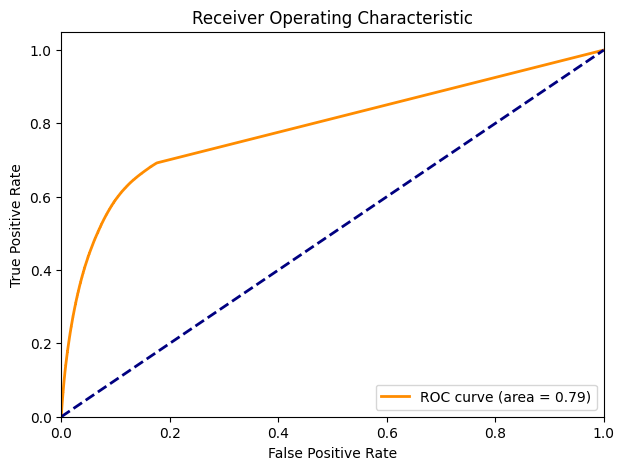

Epoch 1, Train Loss: 0.6591335746055096


Evaluation Progress: 100%|██████████| 1194/1194 [00:01<00:00, 611.68it/s]


Best F1 score: 0.6572
Best threshold: 0.5002


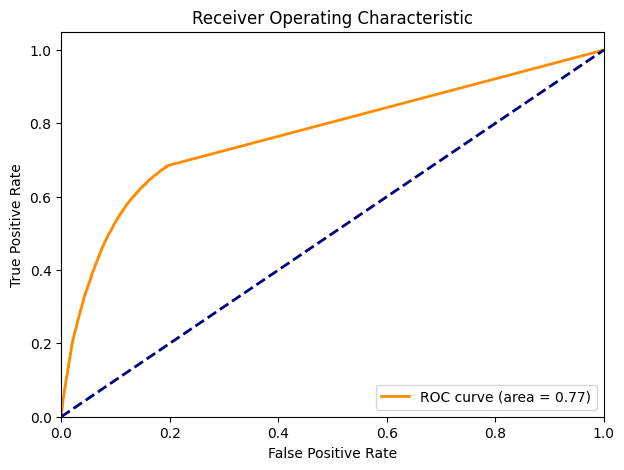

Epoch 1, Test Loss: 0.667220526554277
Epoch 2/5


Evaluation Progress: 100%|██████████| 36807/36807 [01:04<00:00, 572.55it/s]


Best F1 score: 0.6883
Best threshold: 0.5173


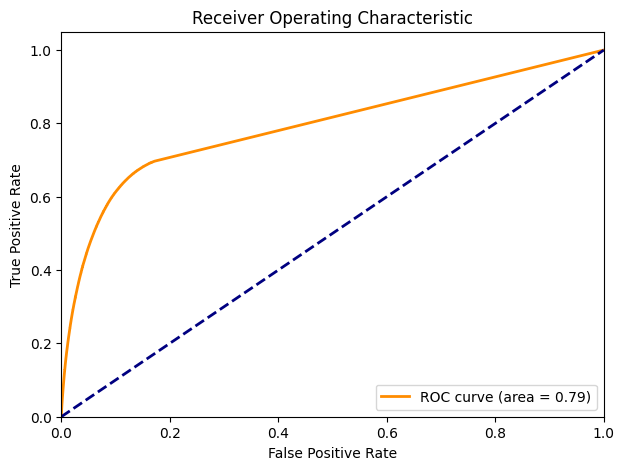

Epoch 2, Train Loss: 0.6574528444563746


Evaluation Progress: 100%|██████████| 1194/1194 [00:02<00:00, 568.18it/s]


Best F1 score: 0.6647
Best threshold: 0.5054


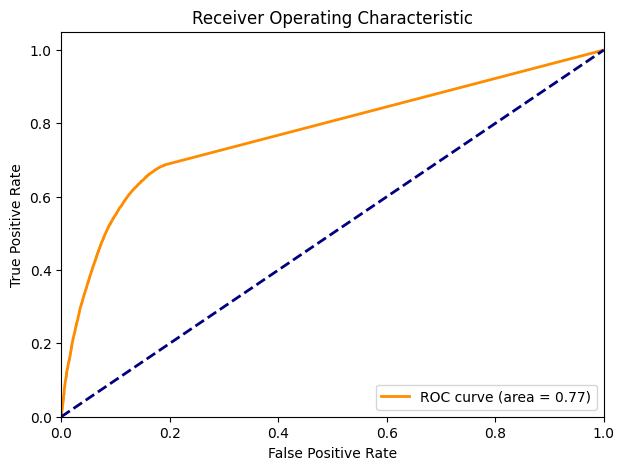

Epoch 2, Test Loss: 0.6657644522249998
Epoch 3/5


Evaluation Progress: 100%|██████████| 36807/36807 [01:01<00:00, 601.03it/s]


Best F1 score: 0.6936
Best threshold: 0.5221


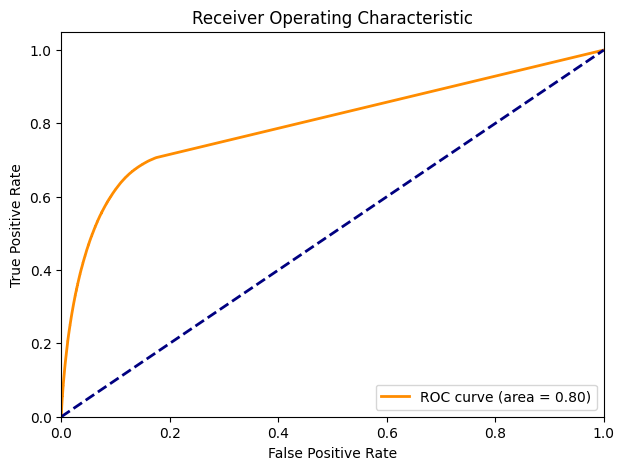

Epoch 3, Train Loss: 0.6568629187467121


Evaluation Progress: 100%|██████████| 1194/1194 [00:02<00:00, 569.99it/s]


Best F1 score: 0.6663
Best threshold: 0.5097


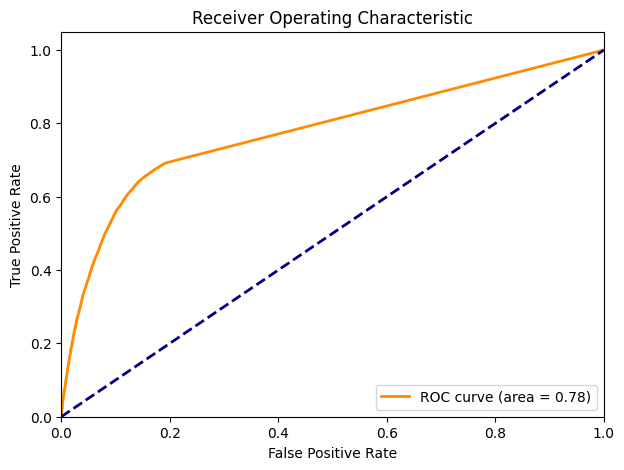

Epoch 3, Test Loss: 0.6654220532432473
Epoch 4/5


Evaluation Progress: 100%|██████████| 36807/36807 [01:00<00:00, 612.96it/s]


Best F1 score: 0.6962
Best threshold: 0.5217


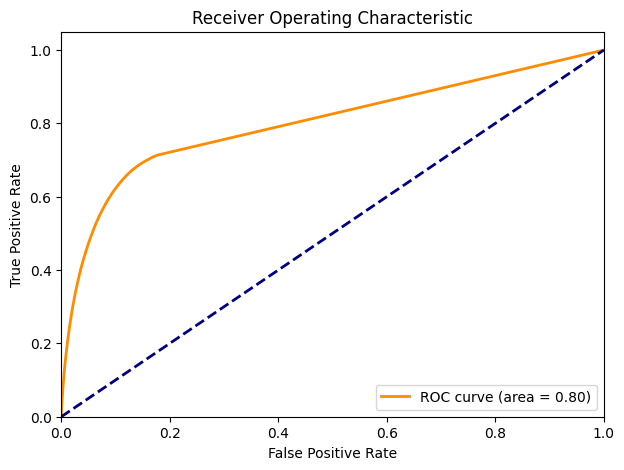

Epoch 4, Train Loss: 0.6565417407773981


Evaluation Progress: 100%|██████████| 1194/1194 [00:01<00:00, 617.19it/s]


Best F1 score: 0.6694
Best threshold: 0.5061


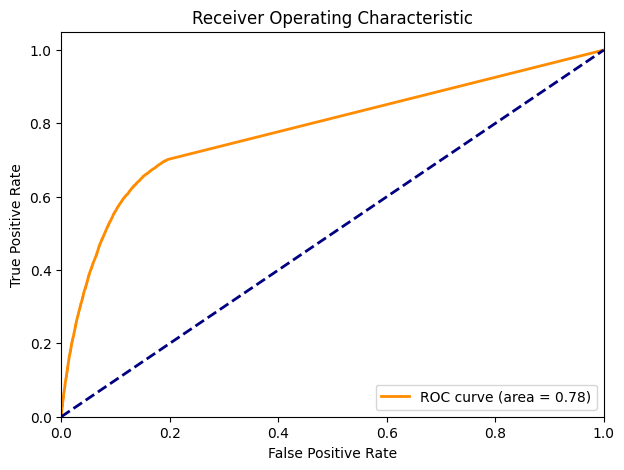

Epoch 4, Test Loss: 0.665144831690956
Epoch 5/5


Evaluation Progress: 100%|██████████| 36807/36807 [01:00<00:00, 607.45it/s]


Best F1 score: 0.6990
Best threshold: 0.5188


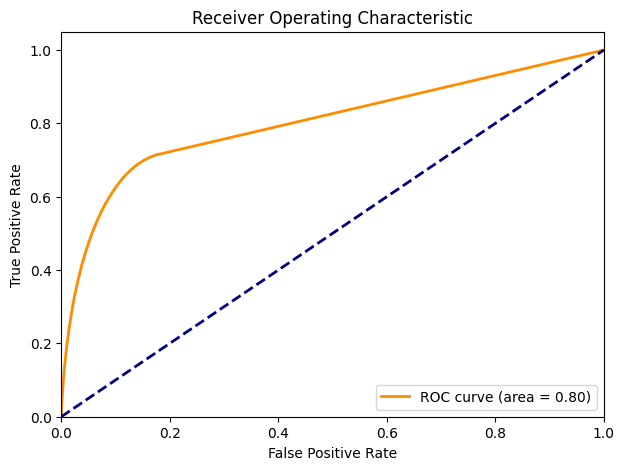

Epoch 5, Train Loss: 0.6562810965578911


Evaluation Progress: 100%|██████████| 1194/1194 [00:02<00:00, 585.28it/s]


Best F1 score: 0.6697
Best threshold: 0.5042


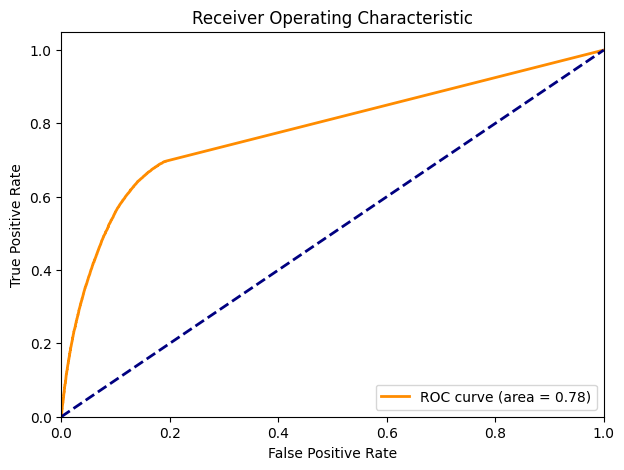

Epoch 5, Test Loss: 0.6652276709151628


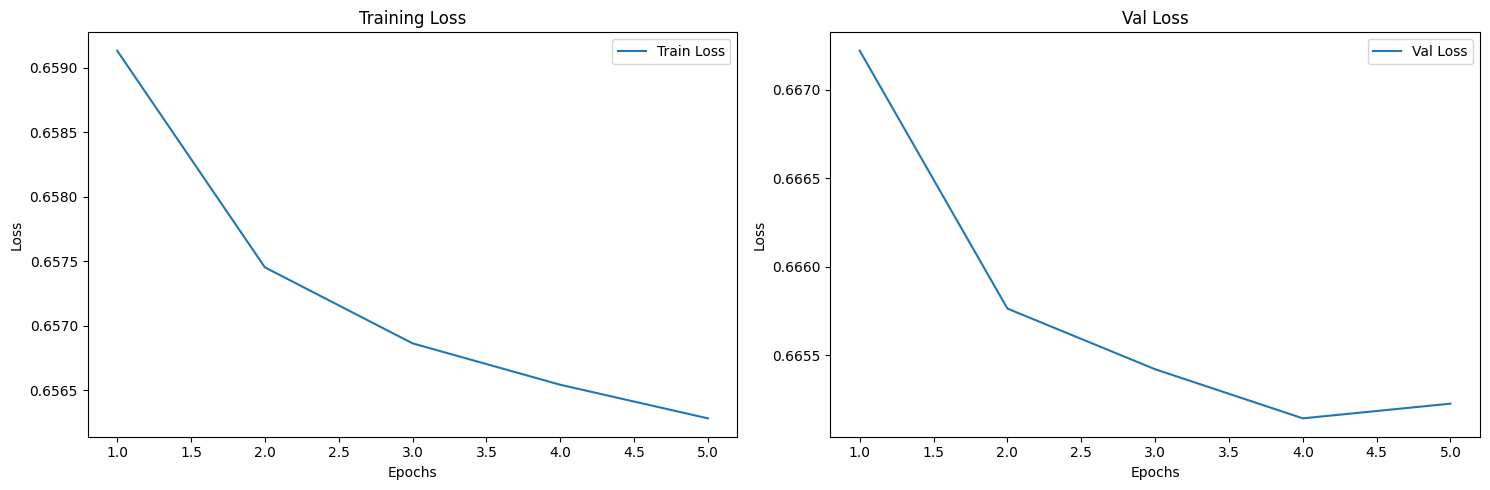

In [5]:
from sklearn.metrics import auc, roc_curve, precision_recall_curve
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm  # Progress bar

def evaluate_model(model, data_loader):
    all_probs = []
    all_labels = []
    batch_num = 0
    epoch_loss = 0
    
    with torch.no_grad():
        for index, (user_features, movie_features, labels) in enumerate(tqdm(data_loader, desc='Evaluation Progress')):
            user_features = user_features.to(device, non_blocking=True)
            movie_features = movie_features.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)
            
            cos_sim = model(user_features, movie_features)
            probs = torch.sigmoid(cos_sim)
            batch_loss = binary_cross_entropy_loss(cos_sim, labels)
            epoch_loss += batch_loss.item()
            batch_num += 1
            
            # 收集所有预测概率和真实标签
            all_probs.append(probs.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
    
    all_probs = np.concatenate(all_probs)
    all_labels = np.concatenate(all_labels)

    loss = epoch_loss/batch_num

    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    roc_auc = auc(fpr, tpr)

    # Compute Precision-Recall Curve for F1
    precision, recall, thresholds = precision_recall_curve(all_labels, all_probs)
    f1_scores = 2 * precision * recall / (precision + recall + 1e-8)
    best_idx = np.argmax(f1_scores)
    best_f1 = f1_scores[best_idx]
    best_threshold = thresholds[best_idx]
    print(f'Best F1 score: {best_f1:.4f}')
    print(f'Best threshold: {best_threshold:.4f}')

    plt.figure(figsize=(7, 5))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()
    return loss

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
recall_model.to(device)
# 使用混合精度训练
scaler = torch.cuda.amp.GradScaler()
optimizer = torch.optim.Adam(recall_model.parameters())

# 训练双塔模型
def train_model(model, train_loader, num_epochs=10):
    model.train()
    epoch_list = [i+1 for i in range(num_epochs)]
    train_loss_list = []
    val_loss_list = []

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        for index, (user_features, movie_features, labels) in enumerate(tqdm(train_loader, desc='Training Progress')):
            user_features = user_features.to(device, non_blocking=True)
            movie_features = movie_features.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            optimizer.zero_grad()
            with torch.cuda.amp.autocast():
                cos_sim = model(user_features, movie_features)
                loss = binary_cross_entropy_loss(cos_sim, labels)
            # 反向传播
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
        model.eval()
        # 计算训练集的损失
        train_loss = evaluate_model(model, train_loader)
        train_loss_list.append(train_loss)
        print(f'Epoch {epoch+1}, Train Loss: {train_loss}')
        # 计算训练集的损失
        val_loss = evaluate_model(model, val_loader)
        print(f'Epoch {epoch+1}, Val Loss: {val_loss}')
        val_loss_list.append(val_loss)

    # 创建一个图形和两个子图，用于显示训练损失和验证损失
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # 在第一个子图中绘制训练损失
    ax1.plot(epoch_list, train_loss_list, label='Train Loss')
    ax1.set_title('Training Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()

    # 在第二个子图中绘制验证损失
    ax2.plot(epoch_list, val_loss_list, label='Val Loss')
    ax2.set_title('Val Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend()

    plt.tight_layout()  # 自动调整子图参数，使之填充整个图像区域
    plt.show()

# 训练模型
num_epochs=3
train_model(recall_model, train_loader, num_epochs)


In [25]:
# 假设 recall_model 是您已经训练好的模型
PATH = './recall_model/TwoTowerModel_CrossEntropyLoss.pth'

# 保存整个模型
torch.save(recall_model, PATH)

In [5]:
# 假设 recall_model 是您已经训练好的模型
PATH = './recall/TwoTowerModel_CrossEntropyLoss.pth'

# 加载整个模型
recall_model = torch.load(PATH)

In [6]:
def generate_dataset_user_movie_dict(dataset, all_user):
    dataset_user_movie_dict = {}
    for item in dataset:
        user_id, movie_id, label = item[0], item[1], item[2]
        if label == 0:
            continue
        if user_id not in dataset_user_movie_dict:
            dataset_user_movie_dict[user_id] = []
        dataset_user_movie_dict[user_id].append(movie_id)
    for user_id in all_user:
        if user_id not in dataset_user_movie_dict:
            dataset_user_movie_dict[user_id] = []
    return dataset_user_movie_dict

train_user_movie_dict = generate_dataset_user_movie_dict(train_list, all_user_set)
val_user_movie_dict = generate_dataset_user_movie_dict(val_list, all_user_set)
test_user_movie_dict = generate_dataset_user_movie_dict(test_list, all_user_set)

user_movie_not_in_train_dict = {}
for user in train_user_movie_dict.keys():
    user_movie_not_in_train_dict[user] = list(all_movie_set - set(train_user_movie_dict[user]))

In [7]:
import torch
from tqdm import tqdm
import json
import numpy as np

# 从JSON文件读取列表
with open('./data/users_without_label_1_list.json', 'r') as file:
    my_list = json.load(file)

device = torch.device("cpu")
recall_model.to(device)
recall_model.eval()

# Precompute all movie feature batches
movie_embedding = {movie: recall_model.get_movie_embedding(torch.tensor(movie_FeatureVector_dict[movie]).unsqueeze(0).to(dtype=torch.float32)).squeeze(0).detach().numpy()
                   for movie in movie_FeatureVector_dict.keys()}

# Precompute user features
user_embedding = {user: recall_model.get_user_embedding(torch.tensor(user_FeatureVector_dict[user]).unsqueeze(0).to(dtype=torch.float32)).squeeze(0).detach().numpy()
                  for user in user_FeatureVector_dict.keys()}

In [8]:
user_movie_sim_dict = {}

with torch.no_grad():
    for user in tqdm(user_movie_not_in_train_dict.keys()):
        movie_list = user_movie_not_in_train_dict[user]
        top_movies = []

        for movie in movie_list:
            sim = np.dot(user_embedding[user], movie_embedding[movie])
            top_movies.append((sim, movie))
        top_movies.sort(reverse=True)
        user_movie_sim_dict[user] = [(movie, sim) for sim, movie in top_movies]

  0%|          | 0/6040 [00:00<?, ?it/s]

100%|██████████| 6040/6040 [00:53<00:00, 112.38it/s]


In [9]:
N = 500

# Calculate recall
true_positive = 0
total_positive = 0

rec_top_N = {key: value[:N] for key, value in user_movie_sim_dict.items()}

for record in val_list:
    user_id, movie_id, label = record
    # if user_id in set(my_list):
    #     continue
    if label == 1:
        total_positive += 1
        top_movies = [movie for movie, _ in rec_top_N.get(user_id, [])]
        if movie_id in top_movies:
            true_positive += 1

recall = true_positive / total_positive if total_positive > 0 else 0
print(f"Recall@{N}: {recall}")
# 不需要精准率，因为推荐总数由N决定，true_positive是固定的，N越大，精准率越小


Recall@500: 0.6599133992770031


In [10]:
import pickle


# 保存字典到文件
with open('./data/val_rectop500_CrossEntropyLoss.pickle', 'wb') as f:
    pickle.dump(user_movie_sim_dict, f)

# 加载字典
# with open('./rectop1000.pickle', 'rb') as f:
#     loaded_data = pickle.load(f)



In [11]:
spark.stop()